# Image Stitching

### 2.1 Coding Questions

In [1]:
import cv2
import copy 
import timeit
import time 
import numpy as np
from matplotlib import pyplot as plt

#### SIFT and Pyramid Image Blending 

In [2]:
"""Compute SIFT keypoints and corresponding descriptors for images 1Hill and 2Hill"""

# reading images to stitch
hill1 = cv2.imread('stitching_images/1Hill.JPG')  # query
hill2 = cv2.imread('stitching_images/2Hill.JPG')  # train
hill3 = cv2.imread('stitching_images/3Hill.JPG')

one_hill = cv2.cvtColor(hill1, cv2.COLOR_BGR2RGB)
two_hill = cv2.cvtColor(hill2, cv2.COLOR_BGR2RGB)
three_hill = cv2.cvtColor(hill3, cv2.COLOR_BGR2RGB)

# compute keypoints & descriptors 
sift_obj = cv2.xfeatures2d.SIFT_create()

startTime_sift =  time.time()
keypoints_two, descriptors_two = sift_obj.detectAndCompute(two_hill, None)
endTime_sift = time.time() 
sift_comp_time = (endTime_sift - startTime_sift)  # computation of sift runtime
keypoints_one, descriptors_one = sift_obj.detectAndCompute(one_hill, None)

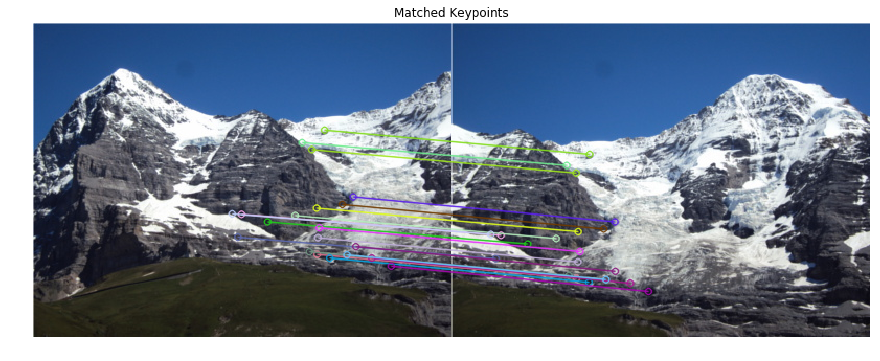

In [3]:
"""Find matching keypoints in two images and display the 20 best pairs"""

# match descriptors 
bf = cv2.BFMatcher()  # Brute-force descriptor matcher 
matches = bf.match(descriptors_one, descriptors_two)

# sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)  # sorted(mylist, key=WhatToSortBy)

# draw 20 best keypoints 
imgmatch = cv2.drawMatches(one_hill, keypoints_one, two_hill, keypoints_two, matches[:20], one_hill, flags=2)

# display results
plt.figure(figsize=(15,15))
plt.subplot(111), plt.imshow(imgmatch)
plt.title('Matched Keypoints'), plt.axis('off')
plt.show()

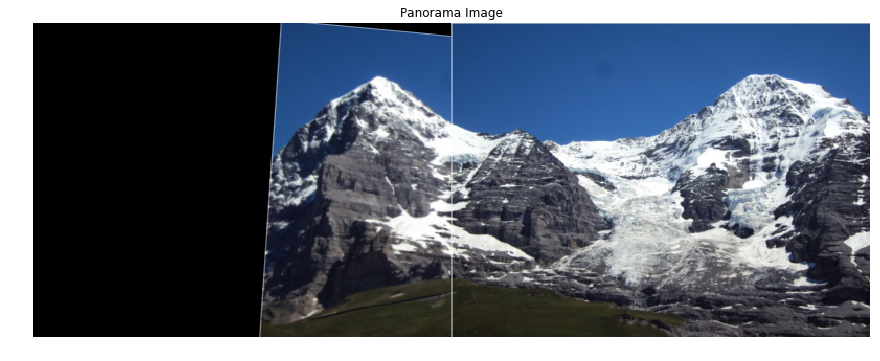

In [4]:
"""Find homography using RANSAC method and apply transformation to 1Hill"""

# arrange matching keypoints in separate lists 
GoodMatches = []
for i, m in enumerate(matches):
    GoodMatches.append((m.trainIdx, m.queryIdx)) 

mp_one = np.float32([keypoints_one[i].pt for (__, i) in GoodMatches])    
mp_two = np.float32([keypoints_two[i].pt for (i, __) in GoodMatches])    

# translation of keypoints in hill_two to the right 
for i in range(len(mp_two)):
    mp_two[i][0] += two_hill.shape[1]

# find homography and warp one_hill accordingly
H, __ = cv2.findHomography(mp_one, mp_two, cv2.RANSAC, 5) 
warp_one = cv2.warpPerspective(one_hill, H, (one_hill.shape[1]+two_hill.shape[1],one_hill.shape[0]))
warp_one_copy = copy.deepcopy(warp_one)

warp_one[:,two_hill.shape[1]:,:] = two_hill

# display results
plt.figure(figsize=(15,15))
plt.subplot(111), plt.imshow(warp_one)
plt.title('Panorama Image'), plt.axis('off')
plt.show()

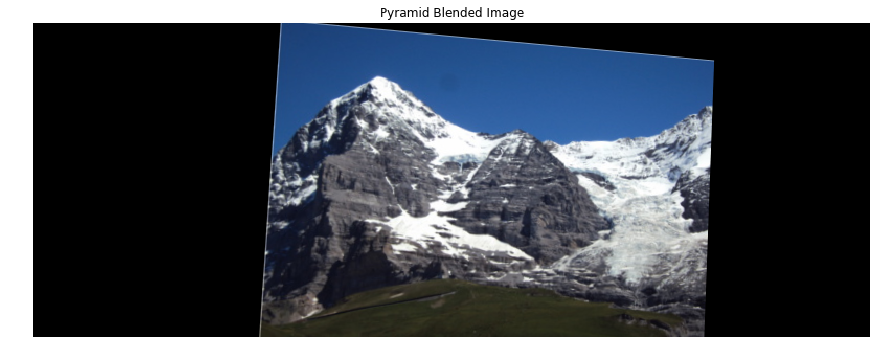

In [5]:
"""Stitch transformed 1Hill and original 2Hill together using pyramid image blending"""

# parameters
depth = 5 # pyramid depth size

# generate Gaussian pyramid for hill_two, warp_one_copy 
G_2, G_1 = two_hill.copy(), warp_one_copy.copy()
gp2, gp1 = [G_2], [G_1]

for i in range(depth):
    # downsample upper pyramid
    G_2 = cv2.pyrDown(G_2)
    G_1 =  cv2.pyrDown(G_1)
    gp2.append(G_2)
    gp1.append(G_1)
    
# generate Laplacian pyramid for hill_two, warp_one_copy
lp_2 = [gp2[depth-1]] # store last gaussian image for top of lp pyramid
lp_1 = [gp1[depth-1]] 

for i in range(depth-1,0,-1):
    # upsample lower pyramid
    hr_2 = cv2.pyrUp(gp2[i], dstsize=(gp2[i-1].shape[1], gp2[i-1].shape[0])) 
    lp = cv2.subtract(gp2[i-1], hr_2, cv2.CV_32F)  # subtract different levels
    lp_2.append(lp)

    hr_1 = cv2.pyrUp(gp1[i], dstsize=(gp1[i-1].shape[1], gp1[i-1].shape[0]))
    lp = cv2.subtract(gp1[i-1], hr_1, cv2.CV_32F)  # subtract different levels
    lp_1.append(lp)  
    
# add left and right halves of images in each level
LP = []
for la, lb in zip(lp_1, lp_2):
    row, cols, dpt = la.shape
    # stack columns (half and half)
    lp = np.hstack((la[:, :round(cols/2)], lb))
    LP.append(lp)
    
# now reconstruct
ls_ = LP[0]
for i in range(1,depth):
    h, w, _ = LP[i].shape
    ls_ = cv2.pyrUp(ls_, dstsize= (w, h))
    ls_ = cv2.add(ls_, LP[i])
    
twelve_hill = copy.deepcopy(ls_) # resultant image to be used in next section

# display results
plt.figure(figsize=(15,15))
plt.subplot(111), plt.imshow(warp_one_copy)
plt.title('Pyramid Blended Image'), plt.axis('off')
plt.show()

#### SURF and Linear Image Blending

In [6]:
"""Compute SURF keypoints and corresponding descriptors for images 12Hill and 3Hill"""

# cvt. images to greyscale 
gray_hill3 = cv2.cvtColor(three_hill, cv2.COLOR_RGB2GRAY)
gray_hill12 = cv2.cvtColor(twelve_hill, cv2.COLOR_RGB2GRAY)

# compute keypoints & descriptors 
surf_obj = cv2.xfeatures2d.SURF_create()

startTime_surf = time.time()
keypoints_twelve, descriptors_twelve = surf_obj.detectAndCompute(gray_hill12, None)
endTime_surf = time.time()
surf_comp_time = (endTime_surf - startTime_surf)  # computation of surf runtime
keypoints_three, descriptors_three = surf_obj.detectAndCompute(gray_hill3, None)

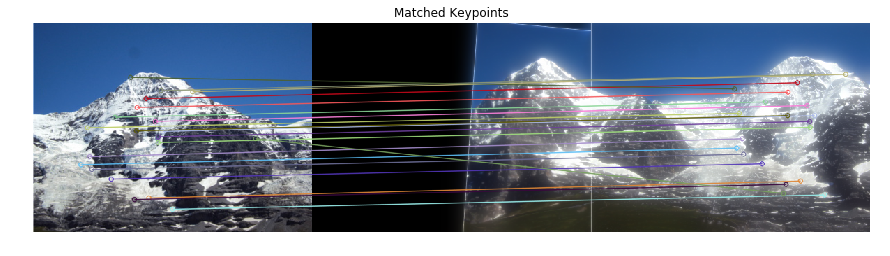

In [7]:
"""Find matching keypoints in two images and display the 20 best pairs"""

# match descriptors 
bf_2 = cv2.BFMatcher()  # Brute-force descriptor matcher 
matches_surf = bf_2.match(descriptors_three, descriptors_twelve)  # why does this need to be in a particular order!?

# sort them in the order of their distance.
matches_surf = sorted(matches_surf, key = lambda x:x.distance)  # sorted(mylist, key=WhatToSortBy)

# draw 20 best keypoints
imgmatch = cv2.drawMatches(three_hill, keypoints_three, twelve_hill, keypoints_twelve, matches_surf[:20], hill3, flags=10)

# display results
plt.figure(figsize=(15,15))
plt.subplot(111), plt.imshow(imgmatch)
plt.title('Matched Keypoints'), plt.axis('off')
plt.show()

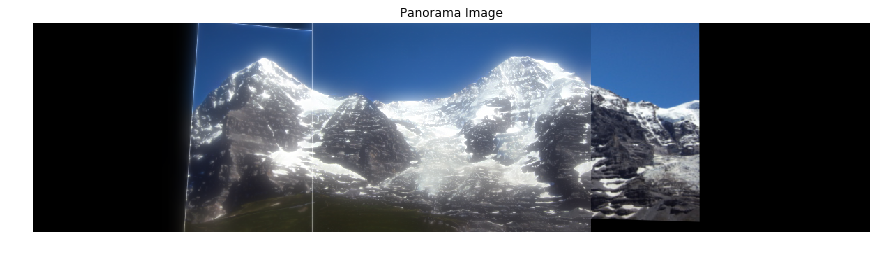

In [38]:
"""Find homography using RANSAC method and apply transformation to 3Hill"""

# arrange matching keypoints in separate lists 
GoodMatches = []
for i, m in enumerate(matches_surf):
    GoodMatches.append((m.trainIdx, m.queryIdx)) 

mp_three = np.float32([keypoints_three[i].pt for (__, i) in GoodMatches])    
mp_twelve = np.float32([keypoints_twelve[i].pt for (i, __) in GoodMatches])    

# translation of keypoints in hill_three to the right 
# for i in range(len(mp_three)):
#     mp_three[i][0] += twelve_hill.shape[1] + three_hill.shape[1]

# find homography and warp one_hill accordingly
H, __ = cv2.findHomography(mp_three, mp_twelve, cv2.RANSAC, 5) 
warp_three = cv2.warpPerspective(three_hill, H, (three_hill.shape[1]+twelve_hill.shape[1],three_hill.shape[0]))
warp_three_copy = copy.deepcopy(warp_three)

warp_three[:,:twelve_hill.shape[1],:] = twelve_hill
# display results
plt.figure(figsize=(15,15))
plt.subplot(111), plt.imshow(warp_three)
plt.title('Panorama Image'), plt.axis('off')
plt.show()

(300, 1200, 3)
(300, 800, 3)
(300, 1200, 3)


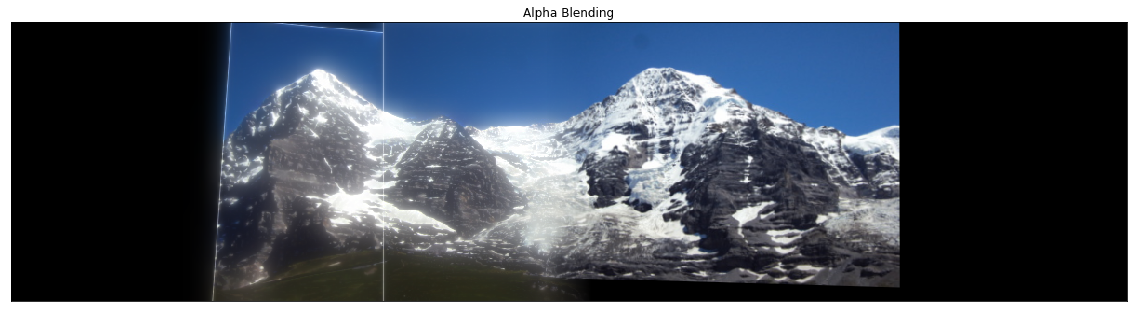

In [9]:
"""Stitch transformed 3Hill and 12Hill together and apply linear image blending"""

col, row = twelve_hill.shape[0:2]

def Ramp(i_width, r_width, r_index, start, end):
    """
    Create alpha blending function
    :param i_width: img width
    :param r_width: ramp width
    :param r_index: center ramp index
    :param start: starting ramp value
    :param end: ending ramp value
    :return:
    """
    a = np.zeros((i_width))
    step = (end - start) / (r_width-1)
    idx = round(r_index - (r_width / 2))  # left side starting index of alpha ramp
    for i in range(r_width):
        a[idx] = start + step*i
        idx += 1
    a[idx:] = 1
    return a

# resizing all images to the largest image size, i.e., warp_three_copy
img1 = np.zeros((warp_three_copy.shape[0], warp_three_copy.shape[1], 3)).astype(np.uint8)
img12 = np.zeros((warp_three_copy.shape[0], warp_three_copy.shape[1], 3)).astype(np.uint8)
img1[:,:warp_three_copy.shape[1],:] = warp_three_copy
img12[:,:twelve_hill.shape[1],:] = twelve_hill

# alpha blending ramp
ramp_size = 50  # alpha blending ramp size
alpha = Ramp(img12.shape[1], ramp_size, round(img12.shape[1]/2), 0, 1)

# # Now blend
I_blend = (1-alpha.reshape(1,-1,1)) * img12 + alpha.reshape(1,-1,1)*img1
I_blend = np.uint8(I_blend)  # convert back to uint8

# display images
plt.figure(figsize=(20,15))
plt.subplot(212), plt.imshow(I_blend)
plt.title("Alpha Blending"), plt.xticks([]), plt.yticks([])
plt.show()

### 2.2 Reasoning Questions

##### 1. What are the differences between SIFT and SURF? Comment on the speed, number of keypoints and density. Support your arguments with statistics.

SIFT involves using Gaussian functions applied in scale space whereas SURF tries to achive the same by approximating with 2D box filters convoluted with integral images. The latter is 3-6 times faster than the former. This is clearly supported by sift_comp_time vs. surf_comp_time. Furthermore, because of the Gaussian functions applied in scale space, there are more keypoints produced via SIFT (keypoints_sift vs. keypoints_surf). SURF is sensitive to illumination, which is clear from the feature images below. The density of keypoints is greater for SURF because the keypoints are greater in radii(because of illumination sensitivity).

sift_comp_time:  0.197221040725708
surf_comp_time:  0.16647911071777344
keypoints_sift:  1217
keypoints_surf:  879


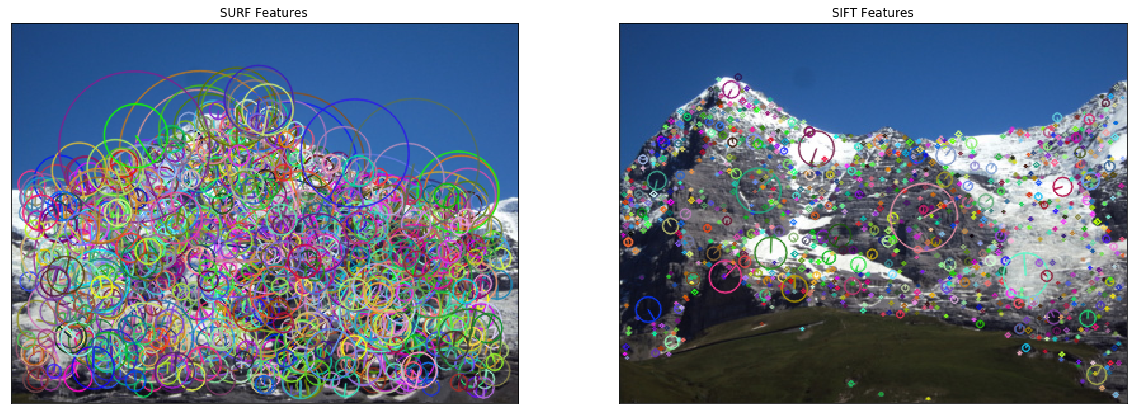

In [37]:
print("sift_comp_time: ", sift_comp_time)
print("surf_comp_time: ", surf_comp_time)
print("keypoints_sift: ", len(keypoints_one))
print("keypoints_surf: ", len(keypoints_three))

display_sift = copy.deepcopy(one_hill)
display_sift = cv2.cvtColor(display_sift, cv2.COLOR_BGR2RGB)
cv2.drawKeypoints(one_hill, keypoints_one, display_sift, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

display_surf = copy.deepcopy(three_hill)
display_surf = cv2.cvtColor(display_surf, cv2.COLOR_BGR2RGB)
cv2.drawKeypoints(three_hill, keypoints_three, display_surf, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)


plt.figure(figsize=(20,20))
# display sift feature density 
plt.subplot(122), plt.imshow(display_sift)
plt.title("SIFT Features"), plt.xticks([]), plt.yticks([])
# display surf feature density 
plt.subplot(121), plt.imshow(display_surf)
plt.title("SURF Features"), plt.xticks([]), plt.yticks([])

plt.show()

##### 2. Discuss at least two pros and cons of pyramid and linear blending techniques. When should one prefer pyramid blending over linear blending?

Linear Blending: performs very well when 1) stitching images together similar textures, 2) computationally simple; 
limited scope in 1) use of images with steep edges, 2) images with many different frequencies

Pyramid Blending: is very promising when 1) handling real-world size variations with a constant-size vision algorithm,          2) blending a wide range of frequencies; cons are 1) computationally very expensive, 2) poor results with similar texture matching 

One should prefer pyramid blending because it takes into account all the various frequencies present in the image which make the result stitched image look much more natural. 

##### 3. What would happen if a random subset of pairs of matching keypoints is used for finding homography?

The resulting homography would be extremely poor and the warped image would be out of place. This is because the difference in matched points would be not minimal which is necessary for a good homography. 

##### 4. Discuss the relationship between the number of pairs of matching key-points used for finding homography and the accuracy of inferred homography.

The number of matching keypoints itself is not a good measure of how well the homography will turn out to be. Amongst the matching keypoints there will also exist 'bad' feature matches. To weed out those, techniques such as RANSAC are used to choose the choice of keypoints that gives the biggest set of inliers. Inferred homography, thus, does not depend on matching keypoints alone. 